In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import shap
seed = 0

In [2]:
df = pd.read_csv('Attrition - Data.csv')
df.head()
df.columns = [val.replace(" ", "_") for val in df.columns]

### Assign 0 and 1 to Has_Payroll column

In [3]:
print(df['Status'].value_counts())

Active      469893
Inactive     28350
Closed        1053
Name: Status, dtype: int64


In [4]:
df['Has_Payroll'] = df['Has_Payroll'].map({'Yes': 1, 'No': 0})
df['Has_Payroll'].value_counts()

0.0    260605
1.0    237781
Name: Has_Payroll, dtype: int64

In [5]:
df

,New_ID,Month,Txn,Status,FUA,Services,Has_Payroll,Has_Investment,Has_VISA,Age,Beacon_score
0,nkm3976380x,201801,3.0,Active,1982.0,1.0,0.0,1.0,1.0,28.0,752.0
1,vaq3809068l,201801,3.0,Active,252.0,1.0,0.0,1.0,1.0,59.0,752.0
2,cct6576683l,201801,1.0,Active,1121.0,2.0,0.0,1.0,1.0,56.0,766.0
3,bia259326m,201801,5.0,Active,2255.0,3.0,0.0,0.0,1.0,21.0,698.0
4,wac199225k,201801,0.0,Active,927.0,2.0,0.0,1.0,0.0,30.0,810.0
...,...,...,...,...,...,...,...,...,...,...,...
499291,chv5135770o,202112,NaN,Closed,NaN,NaN,0.0,NaN,NaN,NaN,NaN
499292,ihz8980045v,202112,NaN,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499293,whu8390349p,202112,NaN,Closed,NaN,NaN,0.0,NaN,NaN,NaN,NaN
499294,liw928837i,202112,NaN,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Filter values

In [6]:
# Filtering Inactice Customers
ia_customers = df[df['Status'] == 'Inactive']['New_ID'].unique()
ia = df[df['New_ID'].isin(ia_customers)].copy()

In [7]:
ia

,New_ID,Month,Txn,Status,FUA,Services,Has_Payroll,Has_Investment,Has_VISA,Age,Beacon_score
8000,pss5916357k,201801,40.0,Active,72644.0,6.0,1.0,0.0,0.0,23.0,676.0
8001,cpb2650834s,201801,40.0,Active,146128.0,8.0,1.0,1.0,0.0,65.0,583.0
8002,zns2509576e,201801,40.0,Active,68916.0,3.0,1.0,1.0,1.0,48.0,636.0
8003,vhl5654249r,201801,40.0,Active,6861.0,8.0,1.0,0.0,0.0,50.0,733.0
8004,byq4563781q,201801,40.0,Active,72093.0,3.0,1.0,1.0,0.0,23.0,730.0
...,...,...,...,...,...,...,...,...,...,...,...
498464,dhf5270771y,202112,0.0,Inactive,0.0,7.0,0.0,1.0,1.0,48.0,563.0
498465,sor1887745h,202112,0.0,Inactive,0.0,3.0,0.0,0.0,0.0,64.0,561.0
498466,jef5887602d,202112,0.0,Inactive,0.0,4.0,0.0,0.0,0.0,65.0,802.0
498467,wbm5409890j,202112,0.0,Inactive,0.0,4.0,0.0,0.0,0.0,57.0,656.0


In [8]:
ia['Next_status'] = ia.groupby('New_ID')['Status'].shift(-13)

In [9]:
ia

,New_ID,Month,Txn,Status,FUA,Services,Has_Payroll,Has_Investment,Has_VISA,Age,Beacon_score,Next_status
8000,pss5916357k,201801,40.0,Active,72644.0,6.0,1.0,0.0,0.0,23.0,676.0,Active
8001,cpb2650834s,201801,40.0,Active,146128.0,8.0,1.0,1.0,0.0,65.0,583.0,Active
8002,zns2509576e,201801,40.0,Active,68916.0,3.0,1.0,1.0,1.0,48.0,636.0,Active
8003,vhl5654249r,201801,40.0,Active,6861.0,8.0,1.0,0.0,0.0,50.0,733.0,Active
8004,byq4563781q,201801,40.0,Active,72093.0,3.0,1.0,1.0,0.0,23.0,730.0,Active
...,...,...,...,...,...,...,...,...,...,...,...,...
498464,dhf5270771y,202112,0.0,Inactive,0.0,7.0,0.0,1.0,1.0,48.0,563.0,NaN
498465,sor1887745h,202112,0.0,Inactive,0.0,3.0,0.0,0.0,0.0,64.0,561.0,NaN
498466,jef5887602d,202112,0.0,Inactive,0.0,4.0,0.0,0.0,0.0,65.0,802.0,NaN
498467,wbm5409890j,202112,0.0,Inactive,0.0,4.0,0.0,0.0,0.0,57.0,656.0,NaN


In [10]:
# Identify True labels
ia_trues = ia[(ia['Status'] == 'Active') & (ia['Next_status'] == 'Inactive')].groupby('New_ID').first().reset_index().copy()
ia_trues['Label'] = 1
ia_trues = ia_trues.drop(columns=['Next_status'])

# Identify False Labels
ia_falses = ia[(ia['Status'] == 'Active') & (ia['Next_status'] == 'Active')].copy().drop(columns=['Next_status'])
ia_falses['Label'] = 0
ia_falses

# Group together
frames = [ia_trues, ia_falses]
ia_all = pd.concat(frames)
ia_all

,New_ID,Month,Txn,Status,FUA,Services,Has_Payroll,Has_Investment,Has_VISA,Age,Beacon_score,Label
0,aad717589k,202006,22.0,Active,54743.0,3.0,0.0,0.0,1.0,61.0,792.0,1
1,aag3298314p,201904,18.0,Active,9791.0,4.0,0.0,1.0,0.0,62.0,697.0,1
2,abn5354584o,201907,28.0,Active,22596.0,5.0,0.0,1.0,0.0,45.0,563.0,1
3,acn828224v,201809,18.0,Active,49209.0,5.0,0.0,0.0,0.0,38.0,793.0,1
4,adl8493318t,201808,23.0,Active,39438.0,5.0,0.0,0.0,0.0,44.0,699.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
300826,dhf5270771y,202005,40.0,Active,75207.0,7.0,1.0,1.0,1.0,47.0,563.0,0
300827,sor1887745h,202005,40.0,Active,171164.0,3.0,1.0,0.0,0.0,63.0,561.0,0
300828,jef5887602d,202005,40.0,Active,27943.0,4.0,1.0,0.0,0.0,64.0,802.0,0
300829,wbm5409890j,202005,40.0,Active,69542.0,4.0,1.0,0.0,0.0,56.0,656.0,0


In [11]:
# Selecting NEW_IDs with closed status values
cc_array = df[df['Status'] == 'Closed']['New_ID'].unique()
cc = df[df['New_ID'].isin(cc_array)].copy()

# Identify rows before churn
cc['Next_status'] = cc.groupby('New_ID')['Status'].shift(-1)

# Mark those rows
conditions = [(cc['Status'] == 'Active') & (cc['Next_status'] == 'Closed')]
values = [1]
cc['Label'] = np.select(conditions, values, default=0)

# Remove irrelavant rows
cc = cc[cc['Status'] != 'Closed'].copy().drop(columns=['Next_status'])
cc

,New_ID,Month,Txn,Status,FUA,Services,Has_Payroll,Has_Investment,Has_VISA,Age,Beacon_score,Label
10351,mdo6140641x,201801,40.0,Active,61922.0,8.0,1.0,1.0,1.0,26.0,745.0,0
10352,llu3698826h,201801,40.0,Active,102174.0,7.0,1.0,0.0,1.0,40.0,604.0,0
10353,img3928586c,201801,40.0,Active,23365.0,6.0,1.0,0.0,1.0,59.0,734.0,0
10354,zvb5892249k,201801,40.0,Active,130183.0,6.0,1.0,1.0,1.0,65.0,759.0,0
10355,vxj1668505h,201801,40.0,Active,137548.0,3.0,0.0,0.0,1.0,51.0,673.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
468058,lsg6780357j,202109,5.0,Active,11960.0,1.0,0.0,1.0,0.0,41.0,603.0,0
468059,eat2407174z,202109,5.0,Active,19935.0,1.0,0.0,0.0,1.0,49.0,748.0,0
478459,syw7770904b,202110,1.0,Active,12093.0,1.0,0.0,1.0,0.0,41.0,603.0,1
478460,lsg6780357j,202110,1.0,Active,12093.0,1.0,0.0,1.0,0.0,41.0,603.0,1


In [12]:
ac = df[~df['New_ID'].isin(np.concatenate((cc, ia), axis=None))].copy()
ac['Label'] = 0
ac.head()

,New_ID,Month,Txn,Status,FUA,Services,Has_Payroll,Has_Investment,Has_VISA,Age,Beacon_score,Label
0,nkm3976380x,201801,3.0,Active,1982.0,1.0,0.0,1.0,1.0,28.0,752.0,0
1,vaq3809068l,201801,3.0,Active,252.0,1.0,0.0,1.0,1.0,59.0,752.0,0
2,cct6576683l,201801,1.0,Active,1121.0,2.0,0.0,1.0,1.0,56.0,766.0,0
3,bia259326m,201801,5.0,Active,2255.0,3.0,0.0,0.0,1.0,21.0,698.0,0
4,wac199225k,201801,0.0,Active,927.0,2.0,0.0,1.0,0.0,30.0,810.0,0


In [13]:
frames = [ia_all, cc, ac]
final = pd.concat(frames)
final = final.sort_values(['New_ID', 'Month'])

In [14]:
final.groupby(['Status'])['Label'].value_counts()

Status  Label
Active  0        449367
        1          1626
Name: Label, dtype: int64

In [15]:
final = final.reset_index(drop=True)

In [17]:
final
df = final

In [18]:
for col in ['FUA', 'Has_Payroll', 'Has_Investment', 'Has_VISA', 'Beacon_score']:
    df = df.sort_values(['New_ID', 'Month'])
    df['{}_diff'.format(col)] = df.groupby('New_ID')[col].diff()
    df['{}_diff'.format(col)] = df['{}_diff'.format(col)].fillna(0)
    df = df.sort_index()

# Creating Final test sets
test_df = df[df['Month'] == 202112].drop(columns="Label") # Removing last month for final test
df = df[df['Month'] <= 202010] # We need to remove the last 12 months from the data (We are unable to get labels from these people)

df.head()

,New_ID,Month,Txn,Status,FUA,Services,Has_Payroll,Has_Investment,Has_VISA,Age,Beacon_score,Label,FUA_diff,Has_Payroll_diff,Has_Investment_diff,Has_VISA_diff,Beacon_score_diff
0,aaa6489015d,201801,46.0,Active,328164.0,8.0,1.0,0.0,0.0,45.0,583.0,0,0.0,0.0,0.0,0.0,0.0
1,aaa6489015d,201802,34.0,Active,328370.0,8.0,1.0,0.0,0.0,45.0,583.0,0,206.0,0.0,0.0,0.0,0.0
2,aaa6489015d,201803,38.0,Active,328380.0,8.0,1.0,0.0,0.0,45.0,583.0,0,10.0,0.0,0.0,0.0,0.0
3,aaa6489015d,201804,0.0,Active,328314.0,8.0,1.0,0.0,0.0,45.0,583.0,0,-66.0,0.0,0.0,0.0,0.0
4,aaa6489015d,201805,44.0,Active,328249.0,8.0,1.0,0.0,0.0,45.0,583.0,0,-65.0,0.0,0.0,0.0,0.0


In [19]:
X_train = df[df['Month'] != 202006].drop(columns=['Label','Month','Status','New_ID'])
y_train = df[df['Month'] != 202006]['Label']

X_valid = df[df['Month'] == 202006].drop(columns=['Label','Month','Status','New_ID'])
y_valid = df[df['Month'] == 202006]['Label']

print("Train: ", len(X_train))
print("Valid: ", len(X_valid))

Train:  319157
Valid:  8858


In [24]:
%%capture 
# capture hides cell output
precisions = []
true_positive_rates = []


def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True


for month in [x for x in df['Month'].unique() if x >= 201806 and x <= 202006]:
    
    # Picking out a specific month
    X_train = df[df['Month'] != month].drop(columns=['Label','Month','Status','New_ID'])
    y_train = df[df['Month'] != month]['Label']

    X_valid = df[df['Month'] == month].drop(columns=['Label','Month','Status','New_ID'])
    y_valid = df[df['Month'] == month]['Label']
    
    # Making Dataset
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
    # Training Model
    params = {
    'boosting': 'gbdt',
    'objective': 'binary',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'verbose': 0
    }
    evals = {}
    print('Starting training...')
    model = lgb.train(params,
                    lgb_train,
                    num_boost_round=25,
                    valid_sets=lgb_eval,
                    callbacks=[lgb.record_evaluation(evals)],
                    feval=lgb_f1_score)
    
    # Predicting top 300 people most likely of churning
    y_pred = model.predict(X_valid)
    ind = np.argpartition(y_pred, -300)[-300:]

    y_pred[ind] = 1
    y_pred = np.where(y_pred < 1, 0, 1)
    
    # Get confusion matrix
    cm = confusion_matrix(y_valid, y_pred, labels=[1,0])
    
    # Adding to precision / accuracy array for each fold
    precisions.append(cm[0,0] / (cm[0,0] + cm[0,1]))
    true_positive_rates.append(cm[0,0] / (cm[0,0] + cm[1,0]))

In [25]:
avg_precision = sum(precisions) / len(precisions)
print("AVG Precision by Fold: {:.4f}".format(avg_precision))

avg_true_pos_rate = sum(true_positive_rates) / len(true_positive_rates)
print("AVG True Pos Rate by Fold: {:.4f}".format(avg_true_pos_rate))

AVG Precision by Fold: 0.9893
AVG True Pos Rate by Fold: 0.2120


In [26]:
X_train = df.drop(columns=['Label','Month','Status','New_ID'])
y_train = df['Label']

X_test = test_df.drop(columns=['Month','Status','New_ID'])

lgb_train = lgb.Dataset(X_train, y_train)

In [27]:
# specify your configurations as a dict
params = {
    'boosting': 'gbdt',
    'objective': 'binary',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'verbose': 0
}
evals = {}
print('Starting training...')
model = lgb.train(params,
                lgb_train,
                num_boost_round=25,
                callbacks=[lgb.record_evaluation(evals)],
                feval=lgb_f1_score)

Starting training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [28]:
y_pred = model.predict(X_train)
ind = np.argpartition(y_pred, -300)[-300:]

y_pred[ind] = 1
y_pred = np.where(y_pred < 1, 0, 1)

In [29]:
y_pred = model.predict(df.drop(columns=['Label','Month','Status','New_ID']))
cm = confusion_matrix(df['Label'], np.round(y_pred), labels=[1,0])

print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[  1560     53]
 [    83 326319]]

True Positives(TP) =  1560

True Negatives(TN) =  326319

False Positives(FP) =  53

False Negatives(FN) =  83


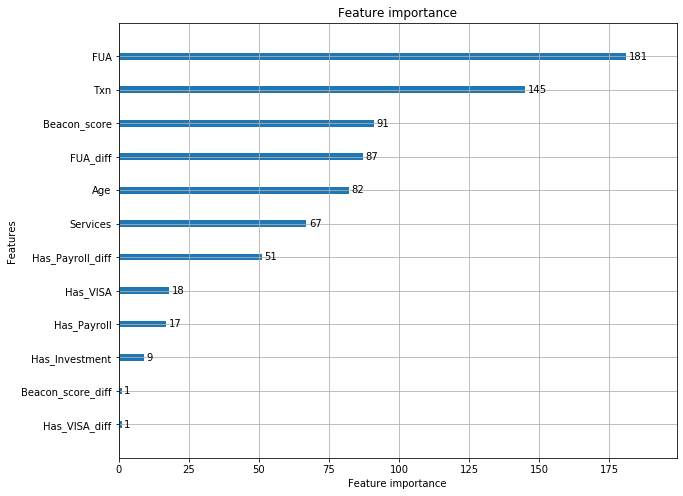

In [30]:
lgb.plot_importance(model, figsize=(10,8))
plt.show()

In [31]:
test_preds = model.predict(X_test)
test_df['pred_prob'] = test_preds
test_df = test_df.sort_values('pred_prob', ascending=False)
test_df.head()

,New_ID,Month,Txn,Status,FUA,Services,Has_Payroll,Has_Investment,Has_VISA,Age,Beacon_score,FUA_diff,Has_Payroll_diff,Has_Investment_diff,Has_VISA_diff,Beacon_score_diff,pred_prob
302355,rfo8777659b,202112,18.0,Active,8164.0,6.0,0.0,1.0,1.0,49.0,588.0,-104301.0,-1.0,0.0,0.0,0.0,0.979998
334656,tas3179350c,202112,18.0,Active,14910.0,3.0,0.0,0.0,1.0,57.0,584.0,-121130.0,-1.0,0.0,0.0,0.0,0.978647
208286,luf8469378c,202112,15.0,Active,3575.0,8.0,0.0,1.0,1.0,33.0,602.0,-109980.0,-1.0,0.0,0.0,0.0,0.970636
238315,nop7040257x,202112,18.0,Active,14281.0,6.0,0.0,0.0,0.0,43.0,635.0,-77898.0,-1.0,0.0,0.0,0.0,0.970561
424460,yib6363832l,202112,18.0,Active,7027.0,6.0,0.0,0.0,0.0,54.0,620.0,-142581.0,-1.0,0.0,0.0,0.0,0.968480


In [32]:
test_df['New_ID'][:300].values

array(['rfo8777659b', 'tas3179350c', 'luf8469378c', 'nop7040257x',
       'yib6363832l', 'zhf158505m', 'jwx948004m', 'xlu9078736z',
       'pws2463270d', 'ywn335996j', 'wzg8807933t', 'pub251638j',
       'oiu3882757j', 'vtq8666877a', 'pts4686012b', 'mbs7877693l',
       'wum4479520s', 'gbl7345067g', 'qjq8483521r', 'vuk6755377f',
       'iph8848781e', 'wjd4187630a', 'cpe2862723w', 'ffm3949487d',
       'zxd210977e', 'rzx1272304e', 'fmw1917521t', 'oct3476098f',
       'ghi2991798z', 'imy7666626h', 'yic8621155o', 'zwp411490t',
       'mlx8353917f', 'wsu2340248h', 'ccn6719628d', 'frg4675768y',
       'cnn5549586u', 'guw8569082f', 'fhx3658150k', 'jon4284899m',
       'txs2181159q', 'jwu3616713t', 'loj6471951t', 'nog4705772y',
       'yoj157160u', 'jzw638755d', 'oet7931321h', 'jec8771467s',
       'bht6135323q', 'mjz7033855m', 'pez3323275f', 'roa3522649m',
       'bvk4808788y', 'erz2643655m', 'ivj8215391c', 'wcy8683040c',
       'qgf2037947v', 'rxt4120944n', 'rzc4431003x', 'uxb4463267d',
   

In [33]:
shap.initjs()

In [34]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


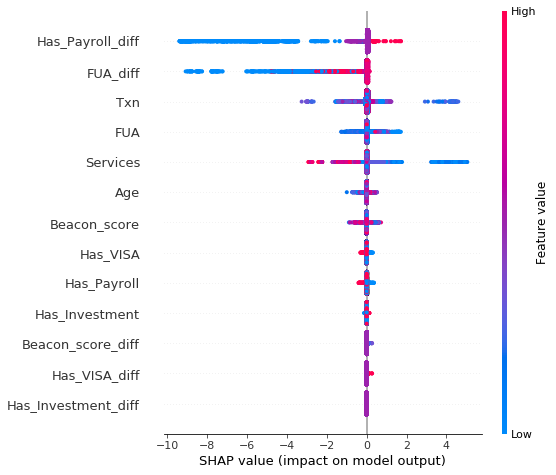

In [35]:
shap.summary_plot(shap_values[0], X_train, plot_type = "dot")

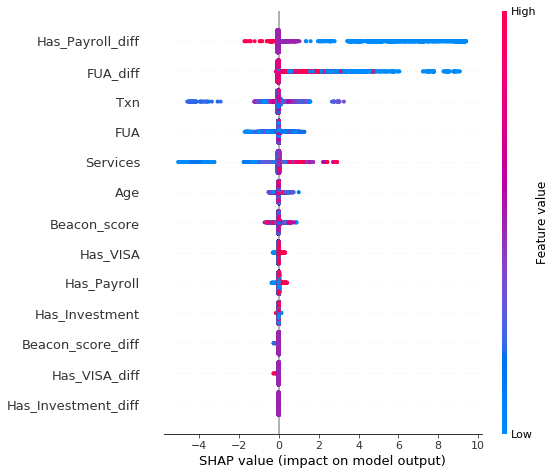

In [36]:
shap.summary_plot(shap_values[1], X_train, plot_type = "dot")